In [16]:
import os
import pickle
import tensorflow as tf
import gym
import numpy as np
import matplotlib.pyplot as plt
import load_policy
import tf_util

# TASK = "Ant-v2"
# TASK = "HalfCheetah-v2"
# TASK = "Hopper-v2"
TASK = "Humanoid-v2"
# TASK = "Reacher-v2"
# TASK = "Walker2d-v2"

# TASK_LIST = ["Ant-v2", "HalfCheetah-v2", "Hopper-v2", "Humanoid-v2", "Reacher-v2", "Walker2d-v2"]

DIRNAME_experts = "experts"
DIRNAME_expert_data = "expert_data"
DIRNAME_MODELS = "DAgger_models"
DIRNAME_output = "output"

BATCH_SIZE = 64
EPOCHS = 50
DAgger_iterations = 10

## Problem 3.1
    We implement the DAgger algorithm as described in lecture. The archiecture of the neural network does not change. The number of DAgger_iteratoins is 10.

In [17]:
def build_train_test_save_model_DAgger(X_train, Y_train, model_path, batch_size=BATCH_SIZE, epochs=EPOCHS):
    
    ret = []
    
    print("The shapes of training input and output: X:{}, Y:{}".format(X_train.shape, Y_train.shape))
    sample_size = X_train.shape[0]
    input_size = X_train.shape[-1]
    output_size = Y_train.shape[-1]
    
    model = tf.keras.Sequential()
    
    # Hidden layer 1: input -> output (64,)
    model.add( tf.keras.layers.Dense(64, input_dim=input_size) )
    model.add( tf.keras.layers.Activation("relu") )
    
    # Hidden layer 2: output (64,) -> output (64,)
    model.add( tf.keras.layers.Dense(64) )
    model.add( tf.keras.layers.Activation("relu") )
    
    # Hidden layer 3: output (64,) -> output
    model.add( tf.keras.layers.Dense(output_size) )
    
    model.compile(loss="mse", optimizer="Adam")
    print("Training model ...")
    
    expert_policy_file = os.path.join(DIRNAME_experts, TASK + ".pkl")
    print('    loading and building expert policy')
    policy_fn = load_policy.load_policy(expert_policy_file)
    print('    loaded and built')

    envname = TASK
    env = gym.make(envname)
    max_steps = env.spec.timestep_limit
    num_rollouts = 20
    
    for i_DAgger in range(DAgger_iterations):
        print("DAgger iter", i_DAgger)
        print(X_train.shape, Y_train.shape)
        model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=epochs, verbose=1)

        rewards = []
        observations = []
        for i in range(num_rollouts):
            print("    iter", i)
            obs = env.reset()
            done = False
            total_reward = 0
            steps = 0
            while not done:
                action = model.predict(obs[None, :], verbose=0)
                observations.append(obs)
                obs, reward, done, _ = env.step(action)
                total_reward += reward
                steps += 1

                if False:
                    env.render()

#                     if steps % 100 == 0:
#                         print("{}/{}".format(steps, max_steps))

                if steps >= max_steps:
                    break

            with tf.Session():
                tf_util.initialize()
                actions = policy_fn( np.array(observations) )

            rewards.append(total_reward)
            
        X_train = np.concatenate( (X_train, observations) )
        Y_train = np.concatenate( (Y_train, actions) )
            
        mean_reward, std_reward = np.mean(rewards), np.std(rewards)
        print("rewards", rewards)
        print("mean reward", mean_reward)
        print("std of reward", std_reward)
        print()
        
        result_dict = {"rewards": rewards, "mean reward": mean_reward, "std of reward": std_reward}
        ret.append(result_dict)
    
    model_dir = os.path.dirname(model_path)
    if not os.path.isdir( model_dir ):
        os.makedirs(model_dir)
        
    model.save(model_path)
    
    return ret


DAgger_dict_list = []

for task in [TASK]:
    model_name = "DAgger_model_" + task + ".h5"
    model_path = os.path.join(DIRNAME_MODELS, model_name)
    
    if not os.path.exists(model_path):
        print("Task {}. DAgger.".format(task))
        datafile = os.path.join(DIRNAME_expert_data, task + ".pkl")
        
        with open(datafile, 'rb') as f:
            expert_data = pickle.load(f)

        X_train = expert_data["observations"]
        Y_train = np.squeeze( expert_data["actions"] )
        
        DAgger_dict_list = build_train_test_save_model_DAgger(X_train, Y_train, model_path)
        print()
        
    else:
        print("Model of " + task + " exists in the directory " + DIRNAME_MODELS + '.')
        print()

Task Humanoid-v2. DAgger.
The shapes of training input and output: X:(20000, 376), Y:(20000, 17)
Training model ...
    loading and building expert policy
obs (1, 376) (1, 376)
    loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
DAgger iter 0
(20000, 376) (20000, 17)
Epoch 1/50
20000/20000 [==============================] - 1s 26us/step - loss: 29.5348
Epoch 2/50
20000/20000 [==============================] - 0s 15us/step - loss: 1.7801
Epoch 3/50
20000/20000 [==============================] - 0s 14us/step - loss: 0.9614
Epoch 4/50
20000/20000 [==============================] - 0s 14us/step - loss: 0.6654
Epoch 5/50
20000/20000 [==============================] - 0s 15us/step - loss: 0.5246
Epoch 6/50
20000/20000 [==============================] - 0s 14us/step - loss: 0.4612
Epoch 7/50
20000/20000 [========================

21772/21772 [==============================] - 0s 15us/step - loss: 0.0540
Epoch 32/50
21772/21772 [==============================] - 0s 16us/step - loss: 0.0545
Epoch 33/50
21772/21772 [==============================] - 0s 15us/step - loss: 0.0536
Epoch 34/50
21772/21772 [==============================] - 0s 15us/step - loss: 0.0533
Epoch 35/50
21772/21772 [==============================] - 0s 15us/step - loss: 0.0529
Epoch 36/50
21772/21772 [==============================] - 0s 14us/step - loss: 0.0528
Epoch 37/50
21772/21772 [==============================] - 0s 14us/step - loss: 0.0518
Epoch 38/50
21772/21772 [==============================] - 0s 14us/step - loss: 0.0523
Epoch 39/50
21772/21772 [==============================] - 0s 14us/step - loss: 0.0505
Epoch 40/50
21772/21772 [==============================] - 0s 14us/step - loss: 0.0505
Epoch 41/50
21772/21772 [==============================] - 0s 14us/step - loss: 0.0500
Epoch 42/50
21772/21772 [==============================

37875/37875 [==============================] - 1s 14us/step - loss: 0.0547
Epoch 9/50
37875/37875 [==============================] - 1s 14us/step - loss: 0.0544
Epoch 10/50
37875/37875 [==============================] - 1s 14us/step - loss: 0.0541
Epoch 11/50
37875/37875 [==============================] - 1s 14us/step - loss: 0.0538
Epoch 12/50
37875/37875 [==============================] - 1s 14us/step - loss: 0.0535
Epoch 13/50
37875/37875 [==============================] - 1s 15us/step - loss: 0.0532
Epoch 14/50
37875/37875 [==============================] - 1s 14us/step - loss: 0.0530
Epoch 15/50
37875/37875 [==============================] - 1s 14us/step - loss: 0.0532
Epoch 16/50
37875/37875 [==============================] - 1s 14us/step - loss: 0.0524
Epoch 17/50
37875/37875 [==============================] - 1s 14us/step - loss: 0.0520
Epoch 18/50
37875/37875 [==============================] - 1s 14us/step - loss: 0.0524
Epoch 19/50
37875/37875 [==============================]

55830/55830 [==============================] - 1s 19us/step - loss: 0.0453
Epoch 45/50
55830/55830 [==============================] - 1s 18us/step - loss: 0.0452
Epoch 46/50
55830/55830 [==============================] - 1s 18us/step - loss: 0.0449
Epoch 47/50
55830/55830 [==============================] - 1s 18us/step - loss: 0.0454
Epoch 48/50
55830/55830 [==============================] - 1s 18us/step - loss: 0.0449
Epoch 49/50
55830/55830 [==============================] - 1s 18us/step - loss: 0.0448
Epoch 50/50
55830/55830 [==============================] - 1s 18us/step - loss: 0.0448
    iter 0
    iter 1
    iter 2
    iter 3
    iter 4
    iter 5
    iter 6
    iter 7
    iter 8
    iter 9
    iter 10
    iter 11
    iter 12
    iter 13
    iter 14
    iter 15
    iter 16
    iter 17
    iter 18
    iter 19
rewards [10392.370651686724, 10376.237397817966, 10290.15432697615, 10282.464417585814, 10270.76494766054, 10203.865378538754, 10370.699520938886, 10313.624013527748, 10207.

93337/93337 [==============================] - 1s 14us/step - loss: 0.0375
Epoch 22/50
93337/93337 [==============================] - 1s 14us/step - loss: 0.0375
Epoch 23/50
93337/93337 [==============================] - 1s 14us/step - loss: 0.0374
Epoch 24/50
93337/93337 [==============================] - 1s 14us/step - loss: 0.0373
Epoch 25/50
93337/93337 [==============================] - 1s 14us/step - loss: 0.0376
Epoch 26/50
93337/93337 [==============================] - 1s 14us/step - loss: 0.0374
Epoch 27/50
93337/93337 [==============================] - 1s 14us/step - loss: 0.0372
Epoch 28/50
93337/93337 [==============================] - 1s 14us/step - loss: 0.0375
Epoch 29/50
93337/93337 [==============================] - 1s 15us/step - loss: 0.0371
Epoch 30/50
93337/93337 [==============================] - 2s 18us/step - loss: 0.0371
Epoch 31/50
93337/93337 [==============================] - 2s 18us/step - loss: 0.0369
Epoch 32/50
93337/93337 [==============================

130984/130984 [==============================] - 2s 14us/step - loss: 0.0333
Epoch 2/50
130984/130984 [==============================] - 2s 14us/step - loss: 0.0334
Epoch 3/50
130984/130984 [==============================] - 2s 14us/step - loss: 0.0333
Epoch 4/50
130984/130984 [==============================] - 2s 14us/step - loss: 0.0333
Epoch 5/50
130984/130984 [==============================] - 2s 14us/step - loss: 0.0335
Epoch 6/50
130984/130984 [==============================] - 2s 14us/step - loss: 0.0334
Epoch 7/50
130984/130984 [==============================] - 2s 14us/step - loss: 0.0333
Epoch 8/50
130984/130984 [==============================] - 2s 14us/step - loss: 0.0333
Epoch 9/50
130984/130984 [==============================] - 2s 14us/step - loss: 0.0332
Epoch 10/50
130984/130984 [==============================] - 2s 14us/step - loss: 0.0332
Epoch 11/50
130984/130984 [==============================] - 2s 14us/step - loss: 0.0332
Epoch 12/50
130984/130984 [==============

150396/150396 [==============================] - 2s 14us/step - loss: 0.0310
Epoch 36/50
150396/150396 [==============================] - 2s 14us/step - loss: 0.0311
Epoch 37/50
150396/150396 [==============================] - 2s 14us/step - loss: 0.0310
Epoch 38/50
150396/150396 [==============================] - 2s 14us/step - loss: 0.0309
Epoch 39/50
150396/150396 [==============================] - 2s 14us/step - loss: 0.0310
Epoch 40/50
150396/150396 [==============================] - 2s 14us/step - loss: 0.0308
Epoch 41/50
150396/150396 [==============================] - 2s 14us/step - loss: 0.0309
Epoch 42/50
150396/150396 [==============================] - 2s 14us/step - loss: 0.0309
Epoch 43/50
150396/150396 [==============================] - 2s 14us/step - loss: 0.0308
Epoch 44/50
150396/150396 [==============================] - 3s 17us/step - loss: 0.0308
Epoch 45/50
150396/150396 [==============================] - 3s 18us/step - loss: 0.0308
Epoch 46/50
150396/150396 [======

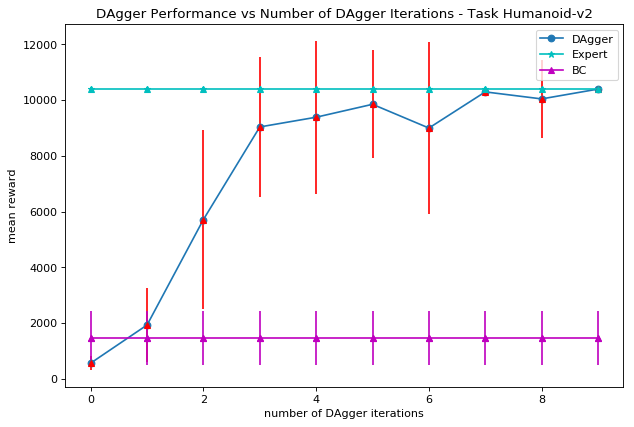

In [21]:
DAgger_iteration_range = range(DAgger_iterations)
performance_means_over_epochs = [ DAgger_dict_list[i]["mean reward"] for i in range(DAgger_iterations) ]
performance_stds_over_epochs = [ DAgger_dict_list[i]["std of reward"] for i in range(DAgger_iterations) ]

expert_mean, expert_std = [10413.67] * DAgger_iterations, [46.43] * DAgger_iterations
BC_mean, BC_std = [1450.24] * DAgger_iterations, [971.65] * DAgger_iterations

plt.figure(figsize=(9, 6), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(DAgger_iteration_range, performance_means_over_epochs, "o-", label="DAgger")
plt.errorbar(DAgger_iteration_range, performance_means_over_epochs, performance_stds_over_epochs,
             color='r', linestyle="None", marker='^')

plt.plot(DAgger_iteration_range, expert_mean, "c*-", label="Expert")
plt.errorbar(DAgger_iteration_range, expert_mean, expert_std,
             color='c', linestyle="None", marker='^')

plt.plot(DAgger_iteration_range, BC_mean, "m^-", label="BC")
plt.errorbar(DAgger_iteration_range, BC_mean, BC_std,
             color='m', linestyle="None", marker='^')

plt.title("DAgger Performance vs Number of DAgger Iterations - Task {}".format(TASK))
plt.xlabel("number of DAgger iterations")
plt.ylabel("mean reward")
plt.legend(loc="best")
plt.savefig( os.path.join(DIRNAME_output, "DAgger_Performance_vs_DAgger_Iterations_" + TASK + ".png") )
plt.show()